# Function

## Not working too slow

In [8]:

import numpy as np
from datetime import datetime
from typing import List, Tuple
from scipy.optimize import minimize
import scipy.sparse
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def fit_vegetation_cycle_with_ramp_functions_and_spatial_penalty(
    time_series: np.ndarray,
    qa: np.ndarray,
    dates: List[datetime],
    max_iter: int = 5,
    tol: float = 1e-2,
    lambda_penalty: float = 0.1,
    verbose=0,
    debug=False
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    logger.info("Starting vegetation cycle fitting function")
    
    # Convert dates to 'datetime64' and compute normalized time as fraction of year
    times_datetime64 = np.array(dates, dtype='datetime64[D]')
    start_date = times_datetime64[0]
    days_since_start = (times_datetime64 - start_date).astype(int)
    t_normalized = days_since_start / 365.25  # Normalize to fraction of year
    t_normalized = np.mod(t_normalized, 1.0)  # Ensure t is between 0 and 1
    t = t_normalized  # Shape: (n_times,)

    n_times = len(t)
    n_rows, n_cols = time_series.shape[1], time_series.shape[2]
    n_pixels = n_rows * n_cols
    logger.info(f"Data dimensions: times={n_times}, rows={n_rows}, cols={n_cols}, pixels={n_pixels}")

    # Reshape time_series and qa for vectorized operations
    y = time_series.reshape(n_times, -1)  # Shape: (n_times, n_pixels)
    weights = qa.reshape(n_times, -1)     # Shape: (n_times, n_pixels)

    # Handle invalid data
    valid_mask = np.isfinite(y) & (weights > 0)
    y = np.where(valid_mask, y, 0)
    weights = np.where(valid_mask, weights, 0)
    logger.info(f"Valid data points: {np.sum(valid_mask)} out of {valid_mask.size}")

    # Initialize t1, t2, t3, t4 for each pixel
    params_init = np.tile([0.2, 0.4, 0.6, 0.8], (n_pixels, 1))  # Shape: (n_pixels, 4)
    logger.info("Initialized parameters for each pixel")

    # ... (ramp and build_design_matrix functions remain the same) ...
    # Define the ramp function
    def ramp(x):
        return np.minimum(np.maximum(x, 0), 1)
    
    # Huber loss function
    def huber_loss(residuals, delta=1.345):
        abs_residuals = np.abs(residuals)
        quadratic = np.minimum(abs_residuals, delta)
        linear = abs_residuals - quadratic
        return 0.5 * quadratic**2 + delta * linear

    # Build the design matrix X for all pixels
    def build_design_matrix(t, params):
        t1, t2, t3, t4 = params[:, 0], params[:, 1], params[:, 2], params[:, 3]  # Shape: (n_pixels,)

        # Ensure no division by zero
        delta_t1 = np.maximum(t2 - t1, 1e-6)
        delta_t2 = np.maximum(t4 - t3, 1e-6)

        # Compute the ramp functions
        R1 = ramp((t[:, None] - t1[None, :]) / delta_t1[None, :])  # Shape: (n_times, n_pixels)
        R2 = ramp((t[:, None] - t3[None, :]) / delta_t2[None, :])  # Shape: (n_times, n_pixels)

        # Seasonal components
        omega = 2 * np.pi
        cos_omega_t = np.cos(omega * t)[:, None]  # Shape: (n_times, 1)
        sin_omega_t = np.sin(omega * t)[:, None]  # Shape: (n_times, 1)

        # Repeat seasonal components for all pixels
        cos_omega_t = np.tile(cos_omega_t, (1, n_pixels))  # Shape: (n_times, n_pixels)
        sin_omega_t = np.tile(sin_omega_t, (1, n_pixels))  # Shape: (n_times, n_pixels)
        ones = np.ones_like(cos_omega_t)  # Offset term

        # Combine into design matrix
        X = np.stack([cos_omega_t, sin_omega_t, ones, R1, R2], axis=2)  # Shape: (n_times, n_pixels, 5)

        return X

    # Objective function for nonlinear optimization
    def objective(params_flat):
        params = params_flat.reshape(n_pixels, 4)  # Shape: (n_pixels, 4)

        # Ensure t1 < t2 < t3 < t4 for each pixel
        t1, t2, t3, t4 = params[:, 0], params[:, 1], params[:, 2], params[:, 3]
        invalid_mask = (t1 >= t2) | (t2 >= t3) | (t3 >= t4) | (t1 < 0) | (t4 > 1)
        if np.any(invalid_mask):
            logger.warning(f"Invalid parameters detected: {np.sum(invalid_mask)} pixels")
            return np.inf

        X = build_design_matrix(t, params)  # Shape: (n_times, n_pixels, 5)

        # Solve for beta using weighted least squares for each pixel
        W = weights
        WX = W[:, :, None] * X  # Shape: (n_times, n_pixels, 5)
        XTWX = np.einsum('tpi,tpi->pi', WX, X)  # Shape: (n_pixels, 5)
        XTWY = np.einsum('tpi,tp->pi', WX, y)   # Shape: (n_pixels, 5)
        beta = XTWY / (XTWX + 1e-8)  # Shape: (n_pixels, 5)

        # Compute residuals
        y_pred = np.einsum('tpi,pi->tp', X, beta)  # Shape: (n_times, n_pixels)
        residuals = y - y_pred  # Shape: (n_times, n_pixels)

        # Compute Huber loss
        loss = huber_loss(residuals)  # Shape: (n_times, n_pixels)
        total_loss = np.sum(W * loss)  # Scalar

        # Compute spatial penalty on harmonic terms
        A = beta[:, 0]  # Shape: (n_pixels,)
        B = beta[:, 1]
        amplitude_harmonic = np.sqrt(A ** 2 + B ** 2)  # Shape: (n_pixels,)
        phase_harmonic = np.arctan2(B, A)
        std_amplitude = np.std(amplitude_harmonic)
        std_phase = np.std(phase_harmonic)
        penalty = lambda_penalty * (std_amplitude + std_phase)

        logger.debug(f"Objective function value: {total_loss + penalty}")
        return total_loss + penalty

    # Bounds for t1, t2, t3, t4 (0 <= t1 < t2 < t3 < t4 <= 1)
    bounds = [(0, 1)] * (4 * n_pixels)

    # Optimization options
    options = {'maxiter': max_iter}

    logger.info("Starting optimization")
    # Perform the optimization
    result = minimize(
        objective,
        params_init.flatten(),
        method='L-BFGS-B',
        bounds=bounds,
        options=options
    )

    if not result.success:
        logger.error("Optimization failed")
        if verbose > 0:
            print("Optimization failed.")
        # Return NaNs
        nan_map = np.full((n_rows, n_cols), np.nan)
        return nan_map, nan_map, nan_map, nan_map, nan_map, nan_map, nan_map, nan_map

    logger.info("Optimization completed successfully")
    logger.info(f"Number of iterations: {result.nit}")
    logger.info(f"Final objective function value: {result.fun}")

    # Optimized t1, t2, t3, t4
    optimized_params = result.x.reshape(n_pixels, 4)  # Shape: (n_pixels, 4)

    logger.info("Recomputing design matrix and beta with optimized parameters")
    # Recompute design matrix and beta with optimized parameters
    X = build_design_matrix(t, optimized_params)  # Shape: (n_times, n_pixels, 5)

    # Solve for beta using weighted least squares for each pixel
    W = weights
    WX = W[:, :, None] * X  # Shape: (n_times, n_pixels, 5)
    XTWX = np.einsum('tpi,tpi->pi', WX, X)  # Shape: (n_pixels, 5)
    XTWY = np.einsum('tpi,tp->pi', WX, y)   # Shape: (n_pixels, 5)
    beta = XTWY / (XTWX + 1e-8)  # Shape: (n_pixels, 5)

    logger.info("Computing final parameters")
    # Extract parameters
    A = beta[:, 0]  # Shape: (n_pixels,)
    B = beta[:, 1]
    c = beta[:, 2]
    a1 = beta[:, 3]
    a2 = beta[:, 4]

    # Compute amplitude and phase of harmonic
    amplitude_harmonic = np.sqrt(A ** 2 + B ** 2)  # Shape: (n_pixels,)
    phase_harmonic = np.arctan2(B, A)  # Shape: (n_pixels,)

    # Compute amplitude and offset of vegetation cycle
    amplitude_vegetation = np.abs(a1) + np.abs(a2)
    offset = c + np.minimum(0, a1) + np.minimum(0, a2)

    logger.info("Reshaping parameters back to spatial dimensions")
    # Reshape parameters back to spatial dimensions
    amplitude_harmonic_map = amplitude_harmonic.reshape(n_rows, n_cols)
    phase_harmonic_map = phase_harmonic.reshape(n_rows, n_cols)
    amplitude_vegetation_map = amplitude_vegetation.reshape(n_rows, n_cols)
    offset_map = offset.reshape(n_rows, n_cols)
    t1_map = optimized_params[:, 0].reshape(n_rows, n_cols)
    t2_map = optimized_params[:, 1].reshape(n_rows, n_cols)
    t3_map = optimized_params[:, 2].reshape(n_rows, n_cols)
    t4_map = optimized_params[:, 3].reshape(n_rows, n_cols)

    logger.info("Vegetation cycle fitting completed")
    return (amplitude_harmonic_map, phase_harmonic_map, amplitude_vegetation_map, offset_map,
            t1_map, t2_map, t3_map, t4_map)

import numpy as np
from joblib import Parallel, delayed
from typing import List, Tuple


def process_chunk(chunk_data: np.ndarray, chunk_qa: np.ndarray, dates: List[datetime], *args, **kwargs) -> Tuple[np.ndarray, ...]:
    """
    Process a single chunk of data.
    """
    return fit_vegetation_cycle_with_ramp_functions_and_spatial_penalty(chunk_data, chunk_qa, dates, *args, **kwargs)

def parallel_fit_vegetation_cycle(
    time_series: np.ndarray,
    qa: np.ndarray,
    dates: List[datetime],
    n_jobs: int = -1,
    n_chunks: int = 4,
    *args,
    **kwargs
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Fit vegetation cycle in parallel using joblib.

    Parameters:
    - time_series: np.ndarray of shape (n_times, n_rows, n_cols)
    - qa: np.ndarray of shape (n_times, n_rows, n_cols)
    - dates: List of datetime objects
    - n_jobs: Number of jobs to run in parallel. -1 means using all processors.
    - n_chunks: Number of chunks to split the data into
    - *args, **kwargs: Additional arguments to pass to the fitting function

    Returns:
    - Tuple of 8 np.ndarrays, each of shape (n_rows, n_cols)
    """
    n_times, n_rows, n_cols = time_series.shape
    chunk_size = n_rows // n_chunks

    # Prepare chunks
    chunks = []
    for i in range(0, n_rows, chunk_size):
        chunk_end = min(i + chunk_size, n_rows)
        chunks.append((
            time_series[:, i:chunk_end, :],
            qa[:, i:chunk_end, :]
        ))

    # Process chunks in parallel
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_chunk)(chunk_data, chunk_qa, dates, *args, **kwargs)
        for chunk_data, chunk_qa in chunks
    )

    # Combine results
    combined_results = tuple(np.concatenate([r[i] for r in results], axis=0) for i in range(8))

    return combined_results



## break detection

In [40]:
import numpy as np
from datetime import datetime
from typing import List, Tuple
from scipy.optimize import minimize
from scipy.signal import find_peaks
from scipy.sparse import diags
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def fit_vegetation_cycle_with_breakpoints(
    time_series: np.ndarray,
    qa: np.ndarray,
    dates: List[datetime],
    max_iter: int = 10,
    tol: float = 1e-2,
    lambda_penalty: float = 0.1,
    delta_huber: float = 1.345,
    verbose=0,
    debug=False
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    # Convert dates to normalized time as fraction of the year
    logger.info("Starting vegetation cycle fitting with breakpoints")
    
    times_datetime64 = np.array(dates, dtype='datetime64[D]')
    start_date = times_datetime64[0]
    days_since_start = (times_datetime64 - start_date).astype(int)
    t = days_since_start / 365.25  # Normalize to fraction of year
    t = np.mod(t, 1.0)  # Ensure t is between 0 and 1
    n_times = len(t)
    
    n_rows, n_cols = time_series.shape[1], time_series.shape[2]
    n_pixels = n_rows * n_cols

    logger.info(f"Data shape: {time_series.shape}, Number of pixels: {n_pixels}")
    logger.info(f"Detecting breakpoints per pixel...")
    
    
    # Reshape time_series and qa for vectorized operations
    y = time_series.reshape(n_times, n_pixels)  # Shape: (n_times, n_pixels)
    weights = qa.reshape(n_times, n_pixels)     # Shape: (n_times, n_pixels)
    
    # Handle invalid data
    valid_mask = np.isfinite(y) & (weights > 0)
    y = np.where(valid_mask, y, 0)
    weights = np.where(valid_mask, weights, 0)
    
    # Initialize t1, t2, t3, t4 per pixel using breakpoint detection
    if verbose > 0:
        print("Detecting breakpoints per pixel...")
    
    t1_init = np.full(n_pixels, 0.2)
    t2_init = np.full(n_pixels, 0.4)
    t3_init = np.full(n_pixels, 0.6)
    t4_init = np.full(n_pixels, 0.8)
    
    for i in range(n_pixels):
        y_pixel = y[:, i]
        w_pixel = weights[:, i]
        valid = valid_mask[:, i]
        if np.sum(valid) > 5:
            # Perform breakpoint detection
            y_valid = y_pixel[valid]
            t_valid = t[valid]
            diffs = np.diff(y_valid)
            # Find peaks in absolute differences
            peaks, _ = find_peaks(np.abs(diffs), distance=len(y_valid)//10)
            if len(peaks) >= 4:
                selected_peaks = peaks[np.argsort(-np.abs(diffs[peaks]))[:4]]
                selected_times = t_valid[selected_peaks]
                selected_times = np.sort(selected_times)
                t1_init[i], t2_init[i], t3_init[i], t4_init[i] = selected_times
            else:
                # Use default initial guesses
                pass
        else:
            # Insufficient data, use default initial guesses
            pass
    
    # Stack t1, t2, t3, t4 into params
    params_init = np.stack([t1_init, t2_init, t3_init, t4_init], axis=1)  # Shape: (n_pixels, 4)
    
    # Design matrix construction function
    def build_design_matrix(t, params):
        n_times = t.shape[0]
        n_pixels = params.shape[0]
        
        t1 = params[:, 0]
        t2 = params[:, 1]
        t3 = params[:, 2]
        t4 = params[:, 3]
        
        # Ensure t1 < t2 < t3 < t4
        invalid_order = (t1 >= t2) | (t2 >= t3) | (t3 >= t4)
        t1[invalid_order] = 0.2
        t2[invalid_order] = 0.4
        t3[invalid_order] = 0.6
        t4[invalid_order] = 0.8
        
        # Avoid division by zero
        delta_t1 = np.maximum(t2 - t1, 1e-6)
        delta_t2 = np.maximum(t4 - t3, 1e-6)
        
        # Time vector expanded
        T = np.tile(t[:, np.newaxis], (1, n_pixels))  # Shape: (n_times, n_pixels)
        
        # Construct piecewise linear functions
        def piecewise_linear(T, t_start, t_end):
            return np.clip((T - t_start) / (t_end - t_start), 0, 1)
        
        R1 = piecewise_linear(T, t1, t2)  # Decrease phase
        R2 = piecewise_linear(T, t3, t4)  # Increase phase
        
        # High plateau
        plateau_high = ((T >= t4) | (T < t1)).astype(float)
        # Low plateau
        plateau_low = ((T >= t2) & (T < t3)).astype(float)
        
        # Combine phases
        veg_cycle = R1 * -1 + R2 * 1 + plateau_high * 1 + plateau_low * 0
        
        # Harmonic components
        omega = 2 * np.pi
        cos_omega_t = np.cos(omega * T)
        sin_omega_t = np.sin(omega * T)
        
        # Offset term
        ones = np.ones_like(T)
        
        # Assemble design matrix
        X = np.stack([cos_omega_t, sin_omega_t, ones, veg_cycle], axis=2)  # Shape: (n_times, n_pixels, 4)
        
        return X  # Shape: (n_times, n_pixels, 4)
    
    # Huber loss function
    def huber_loss(residuals, delta):
        abs_residuals = np.abs(residuals)
        mask = abs_residuals <= delta
        squared_loss = 0.5 * residuals ** 2
        linear_loss = delta * (abs_residuals - 0.5 * delta)
        return np.where(mask, squared_loss, linear_loss)
    
    # Initialize parameters
    params = params_init.copy()
    n_params = 4  # Number of parameters per pixel (t1, t2, t3, t4)
    
    # Initialize weights for IRLS
    W = weights.copy()  # Shape: (n_times, n_pixels)
    epsilon = 1e-8
    
    logger.info("Starting iterative fitting process")
    for iteration in range(max_iter):
        if verbose > 0:
            print(f"Iteration {iteration + 1}")
        
        # Build design matrix
        X = build_design_matrix(t, params)  # Shape: (n_times, n_pixels, 4)
        
        # Solve for beta using weighted least squares
        # Beta includes: [A, B, offset, amplitude_vegetation]
        WX = W[:, :, np.newaxis] * X  # Shape: (n_times, n_pixels, 4)
        XTWX = np.einsum('tpi,tpi->pi', WX, X)  # Shape: (n_pixels, 4)
        XTWY = np.einsum('tpi,tp->pi', WX, y)   # Shape: (n_pixels, 4)
        beta = XTWY / (XTWX + epsilon)          # Shape: (n_pixels, 4)
        
        # Compute residuals
        y_pred = np.einsum('tpi,pi->tp', X, beta)  # Shape: (n_times, n_pixels)
        residuals = y - y_pred  # Shape: (n_times, n_pixels)
        
        # Update weights using Huber loss
        sigma = np.std(residuals, axis=0, keepdims=True) + epsilon
        residuals_scaled = residuals / sigma
        loss = huber_loss(residuals_scaled, delta_huber)
        W_new = 1 / (np.maximum(np.abs(residuals_scaled), delta_huber))
        
        # Spatial penalty on harmonic terms
        A = beta[:, 0]  # Shape: (n_pixels,)
        B = beta[:, 1]
        amplitude_harmonic = np.sqrt(A ** 2 + B ** 2)  # Shape: (n_pixels,)
        phase_harmonic = np.arctan2(B, A)              # Shape: (n_pixels,)
        
        # Compute spatial standard deviation
        std_amplitude = np.std(amplitude_harmonic)
        std_phase = np.std(phase_harmonic)
        
        # Penalty terms (added to residuals)
        penalty_amplitude = lambda_penalty * (amplitude_harmonic - np.mean(amplitude_harmonic))
        penalty_phase = lambda_penalty * (phase_harmonic - np.mean(phase_harmonic))
        
        # Adjust beta to include penalty (only for harmonic terms)
        beta[:, 0] -= penalty_amplitude
        beta[:, 1] -= penalty_phase
        
        # Update weights
        W = W_new * weights
        
        # Check for convergence
        if iteration > 0:
            delta_params = np.linalg.norm(params - params_prev, axis=1)
            if np.all(delta_params < tol):
                if verbose > 0:
                    print("Convergence achieved.")
                break
        
        params_prev = params.copy()
    
    logger.info("Fitting process completed")
    logger.info("Extracting and reshaping final parameters")
    # Extract parameters
    A = beta[:, 0]
    B = beta[:, 1]
    offset = beta[:, 2]
    amplitude_vegetation = beta[:, 3]
    t1 = params[:, 0]
    t2 = params[:, 1]
    t3 = params[:, 2]
    t4 = params[:, 3]
    
    # Compute amplitude and phase of harmonic
    amplitude_harmonic_map = amplitude_harmonic.reshape(n_rows, n_cols)
    phase_harmonic_map = phase_harmonic.reshape(n_rows, n_cols)
    amplitude_vegetation_map = amplitude_vegetation.reshape(n_rows, n_cols)
    offset_map = offset.reshape(n_rows, n_cols)
    t1_map = t1.reshape(n_rows, n_cols)
    t2_map = t2.reshape(n_rows, n_cols)
    t3_map = t3.reshape(n_rows, n_cols)
    t4_map = t4.reshape(n_rows, n_cols)
    logger.info("Returning final results")
    
    return (amplitude_harmonic_map, phase_harmonic_map, amplitude_vegetation_map, offset_map,
            t1_map, t2_map, t3_map, t4_map)





## Breakpoint with just the piecewise linear function

In [58]:
import numpy as np
from datetime import datetime
from typing import List, Tuple
from scipy.signal import find_peaks
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def fit_vegetation_cycle_piecewise_linear(
    time_series: np.ndarray,
    qa: np.ndarray,
    dates: List[datetime],
    max_iter: int = 10,
    tol: float = 1e-2,
    delta_huber: float = 1.345,
    verbose=0,
    debug=False
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Fits a piecewise linear model to the vegetation cycle time series data.

    Parameters:
    - time_series: np.ndarray of shape (n_times, n_rows, n_cols)
    - qa: np.ndarray of shape (n_times, n_rows, n_cols), quality assurance weights
    - dates: List of datetime objects corresponding to the time steps
    - max_iter: Maximum number of iterations for IRLS
    - tol: Tolerance for convergence
    - delta_huber: Delta parameter for Huber loss
    - verbose: Verbosity level
    - debug: Debug mode

    Returns:
    - offset_map: np.ndarray of shape (n_rows, n_cols)
    - amplitude_map: np.ndarray of shape (n_rows, n_cols)
    - t1_map, t2_map, t3_map, t4_map: np.ndarrays of shape (n_rows, n_cols)
    """

    logger.info("Starting vegetation cycle fitting with piecewise linear function")

    # Convert dates to normalized time as fraction of the year
    times_datetime64 = np.array(dates, dtype='datetime64[D]')
    start_date = times_datetime64[0]
    days_since_start = (times_datetime64 - start_date).astype(int)
    t = days_since_start / 365.25  # Normalize to fraction of year
    t = np.mod(t, 1.0)  # Ensure t is between 0 and 1
    n_times = len(t)

    n_rows, n_cols = time_series.shape[1], time_series.shape[2]
    n_pixels = n_rows * n_cols

    logger.info(f"Data shape: {time_series.shape}, Number of pixels: {n_pixels}")

    # Reshape time_series and qa for vectorized operations
    y = time_series.reshape(n_times, n_pixels)  # Shape: (n_times, n_pixels)
    weights = qa.reshape(n_times, n_pixels)     # Shape: (n_times, n_pixels)

    # Handle invalid data
    valid_mask = np.isfinite(y) & (weights > 0)
    y = np.where(valid_mask, y, 0)
    weights = np.where(valid_mask, weights, 0)

    logger.info("Detecting initial breakpoints")
    # Initialize t1, t2, t3, t4 per pixel using breakpoint detection
    t1_init, t2_init, t3_init, t4_init = initialize_breakpoints(y, weights, t, valid_mask)

    # Stack t1, t2, t3, t4 into params
    params = np.stack([t1_init, t2_init, t3_init, t4_init], axis=1)  # Shape: (n_pixels, 4)

    # Initialize weights for IRLS
    W = weights.copy()  # Shape: (n_times, n_pixels)
    epsilon = 1e-8

    logger.info("Starting iterative fitting process")
    for iteration in range(max_iter):
        if verbose > 0:
            print(f"Iteration {iteration + 1}")

        # Build design matrix
        X = build_design_matrix(t, params)  # Shape: (n_times, n_pixels, 2)

        # Solve for beta using weighted least squares
        # Beta includes: [offset, amplitude]
        WX = W[:, :, np.newaxis] * X  # Shape: (n_times, n_pixels, 2)
        XTWX = np.einsum('tpi,tpi->pi', WX, X)  # Shape: (n_pixels, 2)
        XTWY = np.einsum('tpi,tp->pi', WX, y)   # Shape: (n_pixels, 2)
        beta = XTWY / (XTWX + epsilon)          # Shape: (n_pixels, 2)

        # Compute residuals
        y_pred = np.einsum('tpi,pi->tp', X, beta)  # Shape: (n_times, n_pixels)
        residuals = y - y_pred  # Shape: (n_times, n_pixels)

        # Update weights using Huber loss
        sigma = np.std(residuals, axis=0, keepdims=True) + epsilon
        residuals_scaled = residuals / sigma
        W_new = 1 / (np.maximum(np.abs(residuals_scaled), delta_huber) + epsilon)

        # Update weights
        W = W_new * weights

        # Update breakpoints (t1, t2, t3, t4)
        params = update_breakpoints(y, y_pred, t, params, valid_mask)

        # Check for convergence
        if iteration > 0:
            delta_params = np.linalg.norm(params - params_prev, axis=1)
            if np.all(delta_params < tol):
                logger.info(f"Convergence achieved after {iteration + 1} iterations.")
                break

        params_prev = params.copy()

    logger.info("Fitting process completed")
    logger.info("Extracting and reshaping final parameters")

    # Extract parameters
    offset = beta[:, 0]
    amplitude = beta[:, 1]
    t1, t2, t3, t4 = params.T

    # Reshape parameters
    offset_map = offset.reshape(n_rows, n_cols)
    amplitude_map = amplitude.reshape(n_rows, n_cols)
    t1_map = t1.reshape(n_rows, n_cols)
    t2_map = t2.reshape(n_rows, n_cols)
    t3_map = t3.reshape(n_rows, n_cols)
    t4_map = t4.reshape(n_rows, n_cols)

    logger.info("Returning final results")
    return (offset_map, amplitude_map, t1_map, t2_map, t3_map, t4_map)

def initialize_breakpoints(y, weights, t, valid_mask):
    n_pixels = y.shape[1]
    t1_init = np.full(n_pixels, 0.2)
    t2_init = np.full(n_pixels, 0.4)
    t3_init = np.full(n_pixels, 0.6)
    t4_init = np.full(n_pixels, 0.8)

    for i in range(n_pixels):
        y_pixel = y[:, i]
        w_pixel = weights[:, i]
        valid = valid_mask[:, i]
        if np.sum(valid) > 5:
            y_valid = y_pixel[valid]
            t_valid = t[valid]
            diffs = np.diff(y_valid)
            # Find peaks in absolute differences
            peaks, _ = find_peaks(np.abs(diffs), distance=max(len(y_valid)//10, 1))
            if len(peaks) >= 4:
                selected_peaks = peaks[np.argsort(-np.abs(diffs[peaks]))[:4]]
                selected_times = t_valid[selected_peaks]
                selected_times = np.sort(selected_times)
                t1_init[i], t2_init[i], t3_init[i], t4_init[i] = selected_times
            else:
                # Use default initial guesses
                pass
        else:
            # Insufficient data, use default initial guesses
            pass

    return t1_init, t2_init, t3_init, t4_init

def build_design_matrix(t, params):
    n_times = t.shape[0]
    n_pixels = params.shape[0]

    t1, t2, t3, t4 = params.T

    # Ensure t1 < t2 < t3 < t4
    t1, t2, t3, t4 = np.sort(params, axis=1).T

    # Avoid division by zero
    delta_t1 = np.maximum(t2 - t1, 1e-6)
    delta_t2 = np.maximum(t4 - t3, 1e-6)

    # Time vector expanded
    T = t[:, np.newaxis]  # Shape: (n_times, 1)
    T = np.tile(T, (1, n_pixels))  # Shape: (n_times, n_pixels)

    # Broadcast parameters to match T's shape
    t1_broadcasted = t1[np.newaxis, :]  # Shape: (1, n_pixels)
    t2_broadcasted = t2[np.newaxis, :]
    t3_broadcasted = t3[np.newaxis, :]
    t4_broadcasted = t4[np.newaxis, :]
    delta_t1_broadcasted = delta_t1[np.newaxis, :]
    delta_t2_broadcasted = delta_t2[np.newaxis, :]

    # Construct piecewise linear function
    veg_cycle = np.zeros_like(T)

    # High plateau
    mask_high = (T >= t4_broadcasted) | (T < t1_broadcasted)
    veg_cycle[mask_high] = 1

    # Low plateau
    mask_low = (T >= t2_broadcasted) & (T < t3_broadcasted)
    veg_cycle[mask_low] = 0

    # Decrease phase
    mask_decrease = (T >= t1_broadcasted) & (T < t2_broadcasted)
    fraction_decrease = (T - t1_broadcasted) / delta_t1_broadcasted
    veg_cycle[mask_decrease] = 1 - fraction_decrease[mask_decrease]

    # Increase phase
    mask_increase = (T >= t3_broadcasted) & (T < t4_broadcasted)
    fraction_increase = (T - t3_broadcasted) / delta_t2_broadcasted
    veg_cycle[mask_increase] = fraction_increase[mask_increase]

    # Offset term
    ones = np.ones_like(T)

    # Assemble design matrix
    X = np.stack([ones, veg_cycle], axis=2)  # Shape: (n_times, n_pixels, 2)

    return X


def update_breakpoints(y, y_pred, t, params, valid_mask):
    """
    Updates the breakpoints (t1, t2, t3, t4) based on the residuals.

    Parameters:
    - y: Observed data, shape (n_times, n_pixels)
    - y_pred: Predicted data from the model, shape (n_times, n_pixels)
    - t: Time vector, shape (n_times,)
    - params: Current breakpoints, shape (n_pixels, 4)
    - valid_mask: Mask of valid data, shape (n_times, n_pixels)

    Returns:
    - Updated breakpoints, shape (n_pixels, 4)
    """
    n_times, n_pixels = y.shape
    new_params = params.copy()

    residuals = y - y_pred  # Shape: (n_times, n_pixels)

    for i in range(n_pixels):
        residuals_pixel = residuals[:, i]
        valid = valid_mask[:, i]
        t_pixel = t[valid]
        residuals_pixel_valid = residuals_pixel[valid]

        # Use the residuals to find new breakpoints
        # Find peaks in the absolute residuals
        peaks, _ = find_peaks(np.abs(residuals_pixel_valid), distance=max(len(t_pixel)//10, 1))
        if len(peaks) >= 4:
            selected_peaks = peaks[np.argsort(-np.abs(residuals_pixel_valid[peaks]))[:4]]
            selected_times = t_pixel[selected_peaks]
            selected_times = np.sort(selected_times)
            new_params[i] = selected_times
        else:
            # Keep the previous breakpoints if not enough peaks
            new_params[i] = params[i]

    # Ensure t1 < t2 < t3 < t4
    new_params = np.sort(new_params, axis=1)

    return new_params

## Sigmoid function

In [11]:
import numpy as np
from datetime import datetime
from typing import List, Tuple
from scipy.optimize import least_squares
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def fit_vegetation_cycle_with_sigmoids(
    time_series: np.ndarray,
    qa: np.ndarray,
    dates: List[datetime],
    max_iter: int = 100,
    verbose: int = 0
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    logger.info("Starting vegetation cycle fitting with sigmoids")

    # Convert dates to normalized time as fraction of the year
    times_datetime64 = np.array(dates, dtype='datetime64[D]')
    start_date = times_datetime64[0]
    days_since_start = (times_datetime64 - start_date).astype(int)
    t = days_since_start / 365.25  # Normalize to fraction of year
    t = np.mod(t, 1.0)  # Ensure t is between 0 and 1
    n_times = len(t)

    n_rows, n_cols = time_series.shape[1], time_series.shape[2]
    n_pixels = n_rows * n_cols

    logger.info(f"Data shape: {time_series.shape}, Number of pixels: {n_pixels}")

    # Reshape time_series and qa for vectorized operations
    y = time_series.reshape(n_times, n_pixels)  # Shape: (n_times, n_pixels)
    weights = qa.reshape(n_times, n_pixels)     # Shape: (n_times, n_pixels)

    # Handle invalid data
    valid_mask = np.isfinite(y) & (weights > 0)
    y = np.where(valid_mask, y, 0)  # Replace NaNs with 0 instead of keeping them
    weights = np.where(valid_mask, weights, 0)

    logger.info("Preprocessing data completed")

    # Define the sigmoid function with safeguards
    def sigmoid(x, k, x0):
        z = np.clip(k * (x[:, np.newaxis] - x0), -709, 709)  # Prevent overflow
        return 1 / (1 + np.exp(-z))

    # Define the vegetation model function
    def vegetation_model(t, params):
        A, B, k1, x01, k2, x02 = [p.reshape(1, -1) for p in params]
        return A * (1 - sigmoid(t, k1, x01) + sigmoid(t, k2, x02)) + B

    # Function to compute residuals for all pixels
    def residuals(params):
        params_reshaped = params.reshape(6, -1)
        y_pred = vegetation_model(t, params_reshaped)
        res = weights * (y - y_pred)
        return np.nan_to_num(res.ravel(), nan=0.0, posinf=0.0, neginf=0.0)

    logger.info("Initializing parameters")

    # Parameter bounds
    A_bounds = (1e-6, np.inf)  # Avoid zero amplitude
    B_bounds = (-np.inf, np.inf)
    k_bounds = (1e-6, 100)  # Avoid zero or negative steepness
    x0_bounds = (0, 1)

    # Initial parameter guess for all pixels
    A0 = np.clip(np.nanmax(y, axis=0) - np.nanmin(y, axis=0), A_bounds[0], None)
    B0 = np.nanmean(y, axis=0)
    k10 = np.full(n_pixels, 10)
    x010 = np.full(n_pixels, 0.3)
    k20 = np.full(n_pixels, 10)
    x020 = np.full(n_pixels, 0.7)

    initial_guess = np.vstack([A0, B0, k10, x010, k20, x020]).ravel()

    # Ensure initial guess is within bounds
    lower_bounds = np.array([A_bounds[0], B_bounds[0], k_bounds[0], x0_bounds[0], k_bounds[0], x0_bounds[0]] * n_pixels)
    upper_bounds = np.array([A_bounds[1], B_bounds[1], k_bounds[1], x0_bounds[1], k_bounds[1], x0_bounds[1]] * n_pixels)
    initial_guess = np.clip(initial_guess, lower_bounds, upper_bounds)

    logger.info("Starting optimization")

    try:
        result = least_squares(
            residuals,
            x0=initial_guess,
            bounds=(lower_bounds, upper_bounds),
            loss='soft_l1',
            f_scale=0.1,
            max_nfev=max_iter,
            verbose=verbose
        )
        logger.info("Optimization completed successfully")
    except Exception as e:
        logger.error(f"Optimization failed: {str(e)}")
        # Return NaN maps if fitting fails
        return tuple(np.full((n_rows, n_cols), np.nan) for _ in range(6))

    logger.info("Reshaping and returning results")

    # Reshape the results
    params_array = result.x.reshape(6, -1)

    A_map = params_array[0, :].reshape(n_rows, n_cols)
    B_map = params_array[1, :].reshape(n_rows, n_cols)
    k1_map = params_array[2, :].reshape(n_rows, n_cols)
    x01_map = params_array[3, :].reshape(n_rows, n_cols)
    k2_map = params_array[4, :].reshape(n_rows, n_cols)
    x02_map = params_array[5, :].reshape(n_rows, n_cols)

    logger.info("Vegetation cycle fitting completed")

    return A_map, B_map, k1_map, x01_map, k2_map, x02_map

# Postprocessing

In [69]:
# import numpy as np

# def estimate_segments(amplitude_maps, phase_maps, offset_map, dates):
#     """
#     Estimate the segments of the vegetation cycle using harmonic parameters.
    
#     Parameters:
#     amplitude_maps (list): List of amplitude maps for each harmonic.
#     phase_maps (list): List of phase maps for each harmonic.
#     offset_map (np.array): Offset map.
#     dates (list): List of datetime objects representing the dates of the time series.
    
#     Returns:
#     dict: A dictionary containing the estimated start times for each segment as fractions of a year.
#     """
#     # Extract the phase of the first harmonic
#     phase_h1 = phase_maps[0]
    
#     # Convert phase to year fraction
#     # The phase is in radians, ranging from -pi to pi
#     # We convert it to a fraction of a year (0 to 1)
#     year_fraction = (phase_h1 + np.pi) / (2 * np.pi)
    
#     # Define segment durations as fractions of a year
#     increase_duration = 60 / 365.25  # 2 months
#     decrease_duration = 60 / 365.25  # 2 months
#     plateau_duration = 120 / 365.25  # 4 months
    
#     # Shift the cycle start to be at the beginning of the high plateau
#     # This is half a plateau duration before the peak of the cosine function
#     shift = -plateau_duration / 2
    
#     # Calculate segment starts as fractions of a year
#     high_plateau_start = (year_fraction + shift) % 1
#     decrease_start = (high_plateau_start + plateau_duration) % 1
#     low_plateau_start = (decrease_start + decrease_duration) % 1
#     increase_start = (low_plateau_start + plateau_duration) % 1
#     cycle_end = (high_plateau_start + 1) % 1  # Full cycle duration is 1 year
    
#     segments = {
#         'high_plateau_start': high_plateau_start,
#         'decrease_start': decrease_start,
#         'low_plateau_start': low_plateau_start,
#         'increase_start': increase_start,
#         'cycle_end': cycle_end
#     }
    
#     return segments

# import numpy as np
# from datetime import datetime

# def compute_fractional_years_modulo(dates):
#     """
#     Compute the fractional years modulo 1 for each date.

#     Parameters:
#     - dates: list or array of datetime objects

#     Returns:
#     - t_fraction: array of fractions between 0 and 1
#     """
#     reference_date = datetime(2000, 1, 1)
#     days_since_ref = np.array([(date - reference_date).days for date in dates])
#     t_fraction = (days_since_ref % 365.25) / 365.25
#     return t_fraction

# def is_between_vectorized(start, end, t):
#     """
#     Vectorized version of is_between.

#     Parameters:
#     - start: array of shape (1, rows, cols)
#     - end: array of shape (1, rows, cols)
#     - t: array of shape (time, rows, cols)

#     Returns:
#     - mask: array of shape (time, rows, cols), boolean
#     """
#     start = start % 1
#     end = end % 1
#     t = t % 1

#     condition = np.where(
#         start <= end,
#         (t >= start) & (t < end),
#         (t >= start) | (t < end)
#     )
#     return condition

# def create_masks(t_fraction, segments):
#     """
#     Create masks for each segment.

#     Parameters:
#     - t_fraction: array of shape (time,)
#     - segments: dictionary with keys 'high_plateau_start', 'decrease_start', 'low_plateau_start', 'increase_start', 'cycle_end'
#         Each value is an array of shape (rows, cols)

#     Returns:
#     - masks: dictionary with keys 'high_plateau', 'decrease', 'low_plateau', 'increase'
#         Each value is an array of shape (time, rows, cols)
#     """
#     time = t_fraction.shape[0]
#     rows, cols = segments['high_plateau_start'].shape
#     t_fraction_reshaped = t_fraction[:, np.newaxis, np.newaxis]  # shape (time, 1, 1)
#     t_fraction_broadcasted = np.broadcast_to(t_fraction_reshaped, (time, rows, cols))

#     masks = {}

#     # High plateau: from high_plateau_start to decrease_start
#     start = segments['high_plateau_start'][np.newaxis, :, :]
#     end = segments['decrease_start'][np.newaxis, :, :]
#     masks['high_plateau'] = is_between_vectorized(start, end, t_fraction_broadcasted)

#     # Decrease: from decrease_start to low_plateau_start
#     start = segments['decrease_start'][np.newaxis, :, :]
#     end = segments['low_plateau_start'][np.newaxis, :, :]
#     masks['decrease'] = is_between_vectorized(start, end, t_fraction_broadcasted)

#     # Low plateau: from low_plateau_start to increase_start
#     start = segments['low_plateau_start'][np.newaxis, :, :]
#     end = segments['increase_start'][np.newaxis, :, :]
#     masks['low_plateau'] = is_between_vectorized(start, end, t_fraction_broadcasted)

#     # Increase: from increase_start to high_plateau_start (considering wrap-around)
#     start = segments['increase_start'][np.newaxis, :, :]
#     end = segments['high_plateau_start'][np.newaxis, :, :]
#     masks['increase'] = is_between_vectorized(start, end, t_fraction_broadcasted)

#     return masks

# def compute_plateau_levels(y, masks):
#     """
#     Compute the plateau levels L_high and L_low.

#     Parameters:
#     - y: array of shape (time, rows, cols)
#     - masks: dictionary of masks for each segment

#     Returns:
#     - L_high: array of shape (rows, cols)
#     - L_low: array of shape (rows, cols)
#     """
#     L_high_num = np.sum(y * masks['high_plateau'], axis=0)
#     L_high_den = np.sum(masks['high_plateau'], axis=0)
#     L_high = L_high_num / L_high_den
#     L_high = np.where(L_high_den == 0, np.nan, L_high)

#     L_low_num = np.sum(y * masks['low_plateau'], axis=0)
#     L_low_den = np.sum(masks['low_plateau'], axis=0)
#     L_low = L_low_num / L_low_den
#     L_low = np.where(L_low_den == 0, np.nan, L_low)

#     return L_high, L_low

# import numpy as np
# from datetime import datetime

# def compute_intersection_points(L_high, L_low, m, b):
#     """
#     Compute intersection points between plateaus and linear phases.

#     Parameters:
#     - L_high, L_low: arrays of shape (rows, cols)
#     - m, b: slope and intercept arrays of shape (rows, cols)

#     Returns:
#     - t_intersect_high, t_intersect_low: arrays of shape (rows, cols)
#     """
#     with np.errstate(divide='ignore', invalid='ignore'):
#         t_intersect_high = (L_high - b) / m
#         t_intersect_low = (L_low - b) / m

#     # Handle division by zero and infinite intersections
#     mask_zero_slope = (m == 0)
#     t_intersect_high = np.where(mask_zero_slope, np.nan, t_intersect_high)
#     t_intersect_low = np.where(mask_zero_slope, np.nan, t_intersect_low)

#     # Ensure intersections are within [0, 1]
#     t_intersect_high = t_intersect_high % 1
#     t_intersect_low = t_intersect_low % 1

#     return t_intersect_high, t_intersect_low


# def fit_linear_phase(y, t_fraction, mask):
#     """
#     Fit a linear function y = m * t + b to the data in the phase.

#     Parameters:
#     - y: array of shape (time, rows, cols)
#     - t_fraction: array of shape (time,)
#     - mask: array of shape (time, rows, cols)

#     Returns:
#     - m: array of shape (rows, cols)
#     - b: array of shape (rows, cols)
#     - r_squared: array of shape (rows, cols)
#     """
#     time_length, rows, cols = y.shape
#     n_pixels = rows * cols

#     # Reshape y and mask to (time, n_pixels)
#     y_flat = y.reshape(time_length, n_pixels)
#     mask_flat = mask.reshape(time_length, n_pixels)

#     # Reshape t_fraction to (time, 1) for broadcasting
#     t_fraction_reshaped = t_fraction[:, np.newaxis]  # Shape: (time, 1)

#     # Apply mask
#     y_masked = y_flat * mask_flat
#     t_masked = t_fraction_reshaped * mask_flat

#     # Compute sums per pixel
#     n = np.sum(mask_flat, axis=0)  # Shape: (n_pixels,)
#     sum_t = np.sum(t_masked, axis=0)
#     sum_y = np.sum(y_masked, axis=0)
#     sum_t2 = np.sum(t_masked ** 2, axis=0)
#     sum_ty = np.sum(t_masked * y_masked, axis=0)

#     # Compute denominator
#     denom = n * sum_t2 - sum_t ** 2

#     # Avoid division by zero
#     with np.errstate(divide='ignore', invalid='ignore'):
#         m = np.where(denom != 0, (n * sum_ty - sum_t * sum_y) / denom, np.nan)
#         b = np.where(n != 0, (sum_y - m * sum_t) / n, np.nan)

#     # Compute R-squared
#     y_mean = np.where(n != 0, sum_y / n, np.nan)
#     ss_tot = np.sum((y_masked - y_mean) ** 2, axis=0)
#     ss_res = np.sum((y_masked - (m * t_masked + b)) ** 2, axis=0)
#     r_squared = np.where(ss_tot != 0, 1 - (ss_res / ss_tot), np.nan)

#     # Reshape outputs back to (rows, cols)
#     m = m.reshape(rows, cols)
#     b = b.reshape(rows, cols)
#     r_squared = r_squared.reshape(rows, cols)

#     return m, b, r_squared

# def compute_parameters(time_series, dates, segments):
#     """
#     Compute the parameters for the piecewise linear model.

#     Parameters:
#     - time_series: array of shape (time, rows, cols)
#     - dates: list of datetime objects of length time
#     - segments: dictionary with segment start times, each of shape (rows, cols)

#     Returns:
#     - parameters: dictionary with the requested parameters
#     """
#     # Compute t_fraction
#     t_fraction = compute_fractional_years_modulo(dates)  # shape (time,)

#     # Create masks
#     masks = create_masks(t_fraction, segments)  # Each mask is of shape (time, rows, cols)

#     # Extract y
#     y = time_series  # shape (time, rows, cols)

#     # Compute L_high and L_low
#     L_high, L_low = compute_plateau_levels(y, masks)

#     # Compute amplitude and offset
#     amplitude = L_high - L_low
#     offset = L_low

#     # Fit linear functions for increase phase
#     m_increase, b_increase, r_squared_increase = fit_linear_phase(y, t_fraction, masks['increase'])

#     # Compute intersection points for increase phase
#     t_increase_high, t_increase_low = compute_intersection_points(L_high, L_low, m_increase, b_increase)

#     # Compute increase_midpoint and increase_slopeness
#     increase_midpoint = (t_increase_high + t_increase_low) / 2
#     increase_slopeness = m_increase

#     # Fit linear functions for decrease phase
#     m_decrease, b_decrease, r_squared_decrease = fit_linear_phase(y, t_fraction, masks['decrease'])

#     # Compute intersection points for decrease phase
#     t_decrease_high, t_decrease_low = compute_intersection_points(L_high, L_low, m_decrease, b_decrease)

#     # Compute decrease_midpoint and decrease_slopeness
#     decrease_midpoint = (t_decrease_high + t_decrease_low) / 2
#     decrease_slopeness = m_decrease

#     parameters = {
#         'amplitude': amplitude,
#         'offset': offset,
#         'increase_midpoint': increase_midpoint,
#         'increase_slopeness': increase_slopeness,
#         'decrease_midpoint': decrease_midpoint,
#         'decrease_slopeness': decrease_slopeness,
#         't_increase_high': t_increase_high,
#         't_increase_low': t_increase_low,
#         't_decrease_high': t_decrease_high,
#         't_decrease_low': t_decrease_low,
#         'r_squared_increase': r_squared_increase,
#         'r_squared_decrease': r_squared_decrease
#     }

#     # Debug information
#     print("Segments shape:", {k: v.shape for k, v in segments.items()})
#     print("Masks shape:", {k: v.shape for k, v in masks.items()})
#     print("NaN counts:")
#     for key, value in parameters.items():
#         print(f"{key}: {np.isnan(value).sum()} / {value.size}")

#     print("Unique values in increase_slopeness:", np.unique(increase_slopeness))
#     print("Unique values in decrease_slopeness:", np.unique(decrease_slopeness))

#     return parameters

# # Example usage
# # parameters = compute_parameters(time_series, dates, segments)

import numpy as np
from datetime import datetime

def compute_fractional_years_modulo(dates):
    """Compute the fractional years modulo 1 for each date."""
    reference_date = datetime(2000, 1, 1)
    days_since_ref = np.array([(date - reference_date).days for date in dates])
    t_fraction = (days_since_ref % 365.25) / 365.25
    return t_fraction

def is_between_vectorized(start, end, t):
    """Vectorized version of is_between."""
    start, end, t = start % 1, end % 1, t % 1
    return np.where(start <= end, (t >= start) & (t < end), (t >= start) | (t < end))

def create_masks(t_fraction, segments):
    """Create masks for each segment."""
    time = t_fraction.shape[0]
    rows, cols = next(iter(segments.values())).shape  # Get shape from first segment
    t_fraction_broadcasted = np.broadcast_to(t_fraction[:, np.newaxis, np.newaxis], (time, rows, cols))

    masks = {}
    segment_pairs = [
        ('high_plateau', 'decrease'),
        ('decrease', 'low_plateau'),
        ('low_plateau', 'increase'),
        ('increase', 'high_plateau')
    ]

    for start_segment, end_segment in segment_pairs:
        start = segments[f'{start_segment}_start'][np.newaxis, :, :]
        end = segments[f'{end_segment}_start'][np.newaxis, :, :]
        masks[start_segment] = is_between_vectorized(start, end, t_fraction_broadcasted)

    return masks
def compute_plateau_levels(y, masks):
    """Compute the plateau levels L_high and L_low."""
    L_high = np.ma.average(y, weights=masks['high_plateau'], axis=0)
    L_low = np.ma.average(y, weights=masks['low_plateau'], axis=0)
    return L_high.data, L_low.data

def robust_linear_regression(X, Y):
    """Perform robust linear regression using matrix operations."""
    XT_X = X.T @ X
    XT_Y = X.T @ Y
    try:
        XT_X_inv = np.linalg.inv(XT_X)
        beta = XT_X_inv @ XT_Y
    except np.linalg.LinAlgError:
        # If matrix is singular, use pseudo-inverse
        XT_X_inv = np.linalg.pinv(XT_X)
        beta = XT_X_inv @ XT_Y
    return beta[0], beta[1]  # slope, intercept

def fit_linear_phase(y, t_fraction, mask):
    """Fit a linear function y = m * t + b to the data in the phase."""
    time_length, rows, cols = y.shape
    n_pixels = rows * cols

    # Prepare data for regression
    t = t_fraction.reshape(-1, 1)
    X = np.hstack([t, np.ones_like(t)])
    Y = y.reshape(time_length, -1)
    
    # Apply mask
    mask_flat = mask.reshape(time_length, -1)
    X_masked = X[mask_flat.any(axis=1)]
    Y_masked = Y[mask_flat.any(axis=1)]

    # Perform regression for each pixel
    m, b = robust_linear_regression(X_masked, Y_masked)

    return m.reshape(rows, cols), b.reshape(rows, cols)

def compute_intersection_points(L_high, L_low, m, b):
    """Compute intersection points between plateaus and linear phases."""
    with np.errstate(divide='ignore', invalid='ignore'):
        t_intersect_high = (L_high - b) / m
        t_intersect_low = (L_low - b) / m

    # Handle division by zero and infinite intersections
    mask_zero_slope = (np.abs(m) < 1e-10)
    t_intersect_high = np.where(mask_zero_slope, np.nan, t_intersect_high)
    t_intersect_low = np.where(mask_zero_slope, np.nan, t_intersect_low)

    # Ensure intersections are within [0, 1]
    t_intersect_high = t_intersect_high % 1
    t_intersect_low = t_intersect_low % 1

    return t_intersect_high, t_intersect_low

def compute_parameters(time_series, dates, segments):
    """Compute the parameters for the piecewise linear model."""
    t_fraction = compute_fractional_years_modulo(dates)
    masks = create_masks(t_fraction, segments)
    y = time_series

    L_high, L_low = compute_plateau_levels(y, masks)
    amplitude = L_high - L_low
    offset = L_low

    m_increase, b_increase = fit_linear_phase(y, t_fraction, masks['increase'])
    t_increase_high, t_increase_low = compute_intersection_points(L_high, L_low, m_increase, b_increase)
    increase_midpoint = (t_increase_high + t_increase_low) / 2
    increase_slopeness = m_increase

    m_decrease, b_decrease = fit_linear_phase(y, t_fraction, masks['decrease'])
    t_decrease_high, t_decrease_low = compute_intersection_points(L_high, L_low, m_decrease, b_decrease)
    decrease_midpoint = (t_decrease_high + t_decrease_low) / 2
    decrease_slopeness = m_decrease

    parameters = {
        'amplitude': amplitude,
        'offset': offset,
        'increase_midpoint': increase_midpoint,
        'increase_slopeness': increase_slopeness,
        'decrease_midpoint': decrease_midpoint,
        'decrease_slopeness': decrease_slopeness,
        't_increase_high': t_increase_high,
        't_increase_low': t_increase_low,
        't_decrease_high': t_decrease_high,
        't_decrease_low': t_decrease_low
    }

    return parameters

# Diagnostic function
def diagnose_results(parameters):
    """Print diagnostic information about the computed parameters."""
    for key, value in parameters.items():
        if np.isscalar(value):
            print(f"{key}: {value}")
        else:
            print(f"{key}:")
            print(f"  Shape: {value.shape}")
            print(f"  NaN count: {np.isnan(value).sum()}")
            print(f"  Min: {np.nanmin(value)}")
            print(f"  Max: {np.nanmax(value)}")
            print(f"  Mean: {np.nanmean(value)}")
            print(f"  Std: {np.nanstd(value)}")
        print()

# Example usage
# time_series = ...  # Your time series data
# dates = ...  # Your list of dates
# segments = ...  # Your segments dictionary
# parameters = compute_parameters(time_series, dates, segments)
# diagnose_results(parameters)

# Test

In [14]:
import os
import rasterio 
from tqdm import tqdm
from datetime import datetime
import sys
import os

# Add the /src directory to the system path
sys.path.append(os.path.abspath("../src"))
from utils import (load_folder,
                   postprocess_cloud_mask, 
                   fit_periodic_function_with_harmonics_robust) 
from constants import inverse_dfunc

# Define the band and folder paths
band = 'ndvi'
indices = ['crswir', 'ndvi', 'gndvi', 'evi', 'nbr']
folder_dir = '/Users/arthurcalvi/Data/species/validation/tiles_2_5_km'

# Get the list of files
files = os.listdir(folder_dir)
files = sorted([f for f in files if os.path.isdir(os.path.join(folder_dir, f))], key=lambda x: int(x.split('_')[1]))
path = os.path.join(folder_dir, files[119])
print(f"Processing path: {path}")

# Load data
indices_ = ['r', 'g', 'b'] + [index for index in indices if index != 'rgb']
dates = [datetime.strptime(filename.split('_')[0], '%Y-%m-%d') for filename in os.listdir(os.path.join(path, 'rgb'))]
dates.sort()

# Load indices
dict_indices = {index: inverse_dfunc[index](load_folder(os.path.join(path, index)) / 65535) for index in indices}

# Load QA data
qa = load_folder(os.path.join(path, 'qa'))

# Process QA mask
new_qa = []
for frame in tqdm(qa, desc="Processing QA masks"):
    frame_ = np.zeros_like(frame)
    mask = (frame == 1) | (frame == 3) | (frame == 6) | (frame == 8) | (frame == 9) | (frame == 10) | (frame == 11)
    frame_[mask] = 1
    frame_ = postprocess_cloud_mask(frame_, 5, 25)
    new_qa.append(frame_)
qa_mask = np.array(new_qa)
weights = 1 - qa_mask  # Inverse mask for weights

# Load DEM profile for later use
dir_dem = os.path.join(path, 'dem.tif')
with rasterio.open(dir_dem) as src:
    profile = src.profile

# Select the band to process
time_series = dict_indices[band]

# --- New code to filter data to one year ---
# Choose the year of interest
year_of_interest = 2022

# Create a boolean mask for dates in the specified year
date_mask = np.array([date.year == year_of_interest for date in dates])

# Check if there are any dates in the year of interest
if not np.any(date_mask):
    raise ValueError(f"No data available for the year {year_of_interest}.")

# Filter the dates
dates_filtered = [date for date in dates if date.year == year_of_interest]

# Convert to numpy array for indexing
date_indices = np.where(date_mask)[0]

# Filter the time_series and weights arrays
time_series_filtered = time_series[date_indices, :, :]
weights_filtered = weights[date_indices, :, :]

# --- End of new code ---

# Call the function with filtered data
# offset_map, amplitude_map, t1_map, t2_map, t3_map, t4_map = fit_vegetation_cycle_piecewise_linear(
#     time_series_filtered, weights_filtered, dates_filtered, max_iter=10, tol=1e-2, delta_huber=1.345, verbose=1
# )

# amplitude_harmonic_map, phase_harmonic_map, amplitude_vegetation_map, offset_map, t1_map, t2_map, t3_map, t4_map = fit_vegetation_cycle_with_breakpoints(
#     time_series_filtered, weights_filtered, dates_filtered, max_iter=10, tol=1e-2, lambda_penalty=0.1, delta_huber=1.345, verbose=1
# )

# Usage
# A, B, decrease_time, increase_time = fit_vegetation_cycle(time_series, qa, dates)

# A_map, B_map, k1_map, x01_map, k2_map, x02_map = fit_vegetation_cycle_with_sigmoids(
#     time_series_filtered, weights_filtered, dates_filtered, max_iter=10, verbose=1
# )

results = fit_periodic_function_with_harmonics_robust(time_series, weights, dates,
    num_harmonics = 2) 


# Continue with your processing, such as saving the results


Processing path: /Users/arthurcalvi/Data/species/validation/tiles_2_5_km/tile_123_20201127_20240204_Massif_central


Processing QA masks:   0%|          | 0/22 [00:00<?, ?it/s]/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_16857/664834915.py:43: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  frame_ = postprocess_cloud_mask(frame_, 5, 25)
Processing QA masks: 100%|██████████| 22/22 [00:00<00:00, 31.53it/s]


amplitude:
  Shape: (254, 254)
  NaN count: 0
  Min: -0.7303273060196843
  Max: 0.5344747081712061
  Mean: -0.20202875937152323
  Std: 0.15351605082735134

offset:
  Shape: (254, 254)
  NaN count: 0
  Min: 0.04876783398184181
  Max: 0.9347524223697261
  Mean: 0.7636155718167632
  Std: 0.10160125993139586

increase_midpoint:
  Shape: (254, 254)
  NaN count: 0
  Min: 0.0015321427115668783
  Max: 0.9974478877428703
  Mean: 0.5344816222250842
  Std: 0.2093812424568398

increase_slopeness:
  Shape: (254, 254)
  NaN count: 0
  Min: -0.3789662066308377
  Max: 0.6952656117839939
  Mean: 0.0966113307937016
  Std: 0.14766892514906366

decrease_midpoint:
  Shape: (254, 254)
  NaN count: 0
  Min: 0.0015321427115668783
  Max: 0.9974478877428703
  Mean: 0.5344816222250842
  Std: 0.2093812424568398

decrease_slopeness:
  Shape: (254, 254)
  NaN count: 0
  Min: -0.3789662066308377
  Max: 0.6952656117839939
  Mean: 0.0966113307937016
  Std: 0.14766892514906366

t_increase_high:
  Shape: (254, 254)
  Na

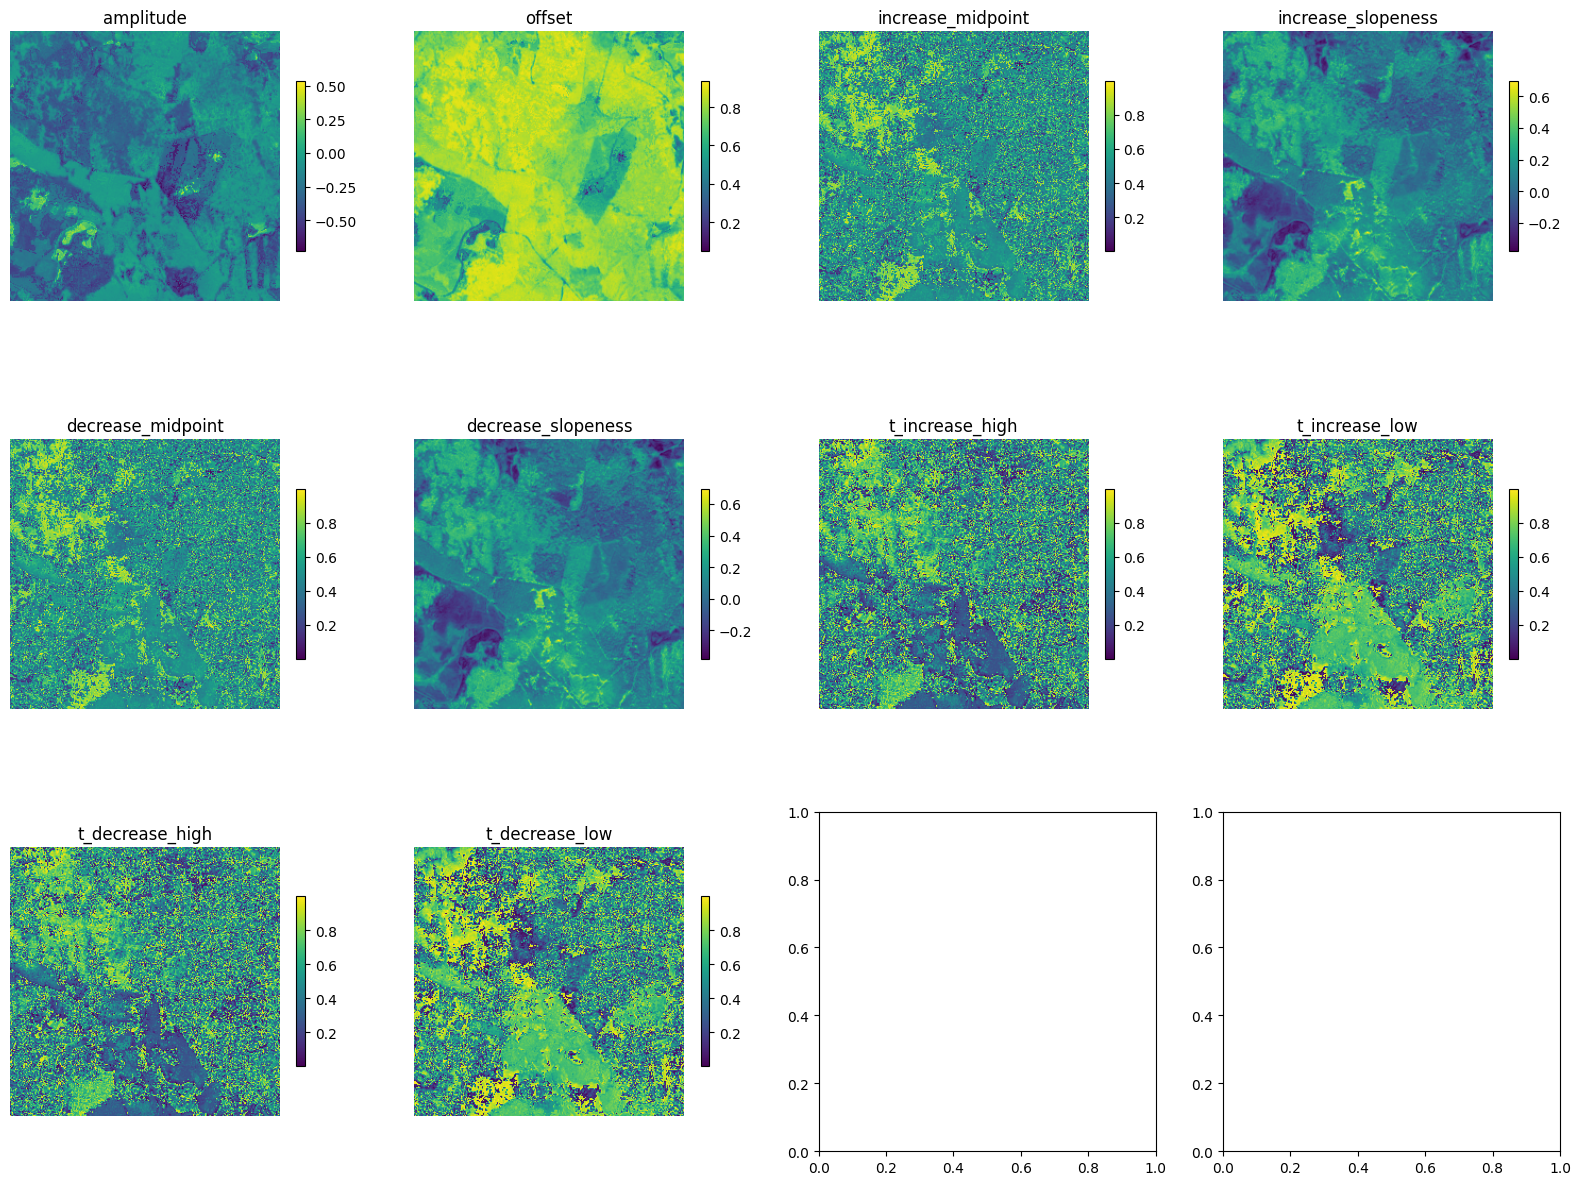

In [70]:
segments = estimate_segments(results[:2], results[2:4], results[4], dates_filtered)
# Compute the parameters
parameters = compute_parameters(time_series, dates, segments)
diagnose_results(parameters)

import matplotlib.pyplot as plt
n = len(parameters)
nrows = n // 4 + 1
ncols = 4
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 5 * nrows))

if nrows > 1:
    axes = axes.flatten()

i = 0
for key, value in parameters.items():
    print(f"{key}: {value.shape}")
    ax = axes[i]
    im = ax.imshow(value)
    #add colorbar
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.5)
    ax.set_title(key)
    ax.set_axis_off()
    i+=1
    
plt.show()


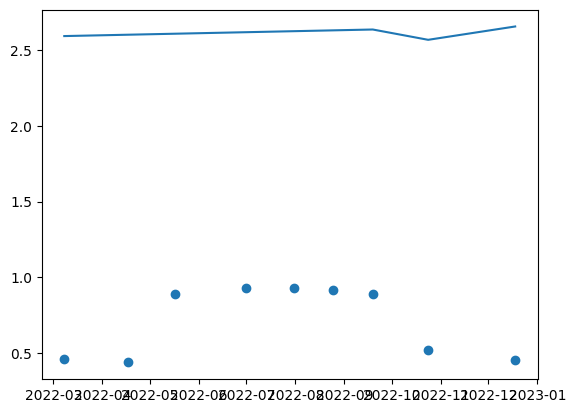

In [39]:
row, col = 100, 100
plt.scatter(dates_filtered, time_series_filtered[:, row, col], label='Original')
plt.plot(dates_filtered, piecewise_values[:, row, col], label='Piecewise')

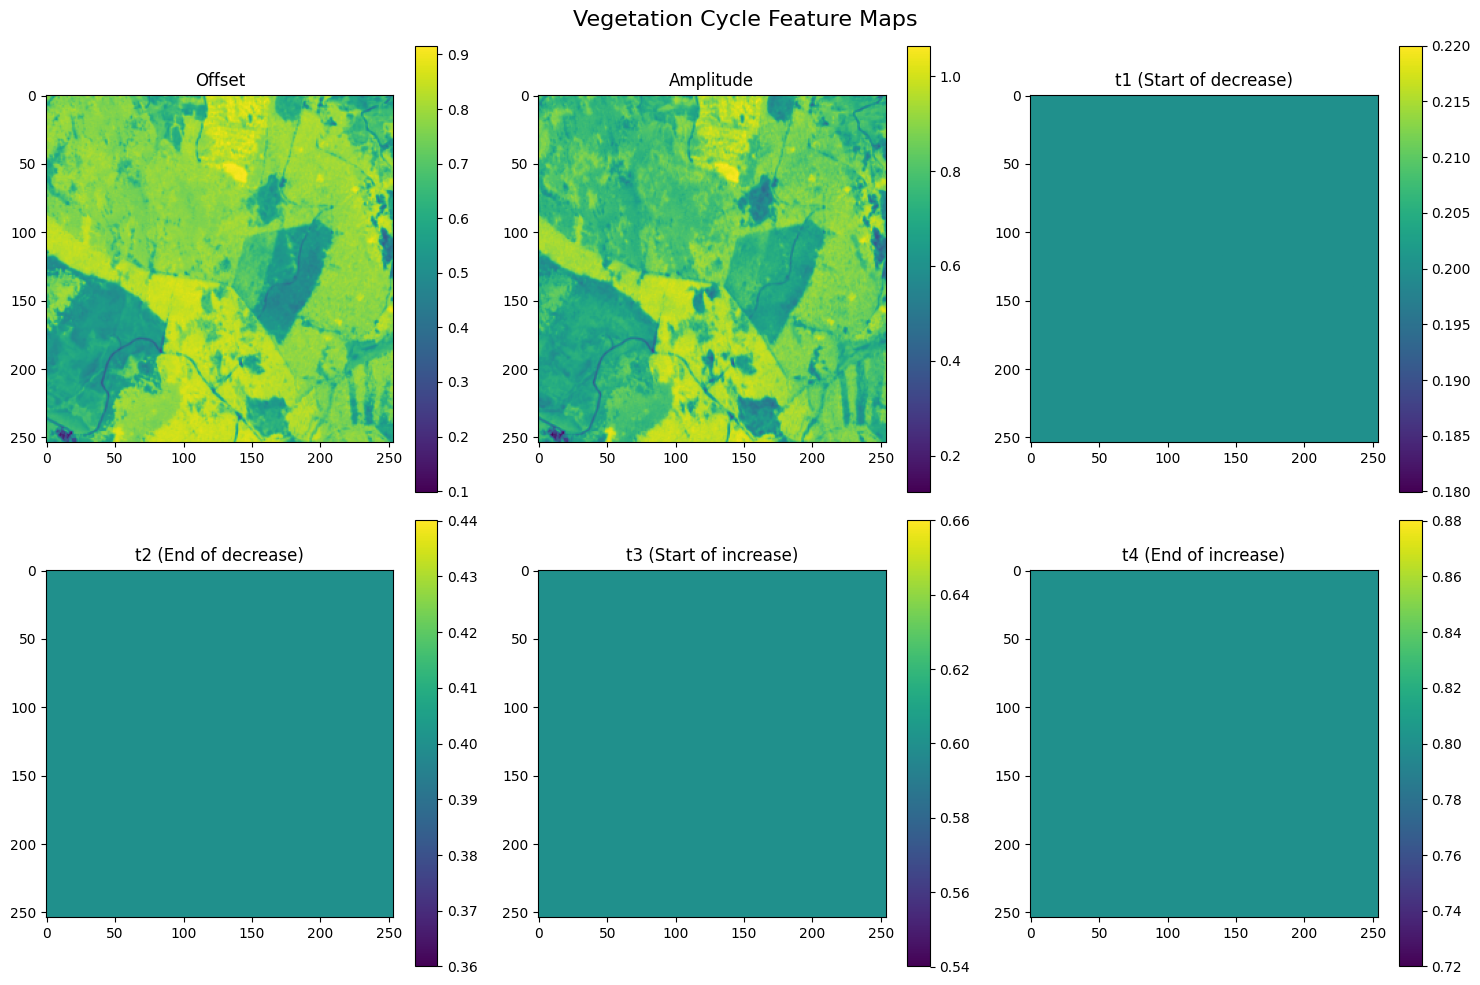

In [62]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_maps(offset_map, amplitude_map, t1_map, t2_map, t3_map, t4_map):
    """
    Plots feature maps for the piecewise linear vegetation cycle model.
    
    Parameters:
    - offset_map, amplitude_map, t1_map, t2_map, t3_map, t4_map: 2D numpy arrays
    """
    feature_maps = [
        ('Offset', offset_map),
        ('Amplitude', amplitude_map),
        ('t1 (Start of decrease)', t1_map),
        ('t2 (End of decrease)', t2_map),
        ('t3 (Start of increase)', t3_map),
        ('t4 (End of increase)', t4_map)
    ]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Vegetation Cycle Feature Maps', fontsize=16)
    
    for (title, feature_map), ax in zip(feature_maps, axes.flatten()):
        im = ax.imshow(feature_map, cmap='viridis')
        ax.set_title(title)
        plt.colorbar(im, ax=ax)
    
    plt.tight_layout()
    plt.show()

# Usage example:
plot_feature_maps(offset_map, amplitude_map, t1_map, t2_map, t3_map, t4_map)

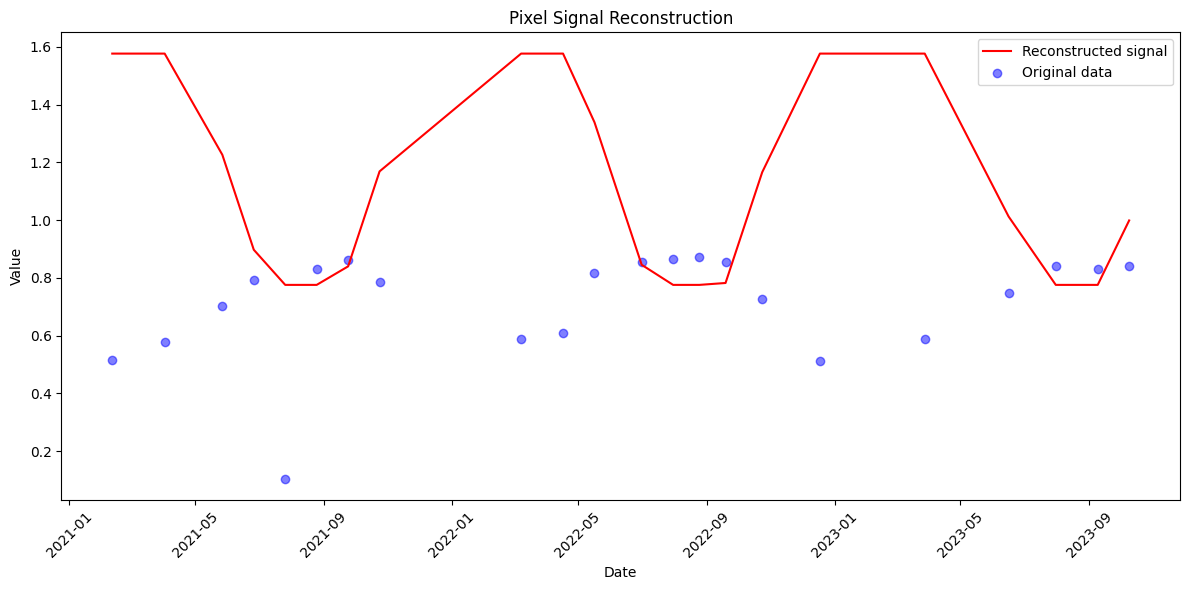

array([1.57641766, 1.57641766, 1.22612811, 0.89721774, 0.7755209 ,
       0.7755209 , 0.83965842, 1.1685688 , 1.57641766, 1.57641766,
       1.33850582, 0.84514026, 0.7755209 , 0.7755209 , 0.7820991 ,
       1.16582788, 1.57641766, 1.57641766, 1.01233637, 0.7755209 ,
       0.7755209 , 0.99863177])

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

def reconstruct_pixel_signal(pixel_params: tuple, dates: List[datetime], original_data: np.ndarray = None):
    """
    Reconstructs and plots the signal for a single pixel.
    
    Parameters:
    - pixel_params: tuple (offset, amplitude, t1, t2, t3, t4)
    - dates: List of datetime objects corresponding to the time steps
    - original_data: Optional, original pixel data for comparison
    """
    offset, amplitude, t1, t2, t3, t4 = pixel_params
    
    # Convert dates to normalized time
    times_datetime64 = np.array(dates, dtype='datetime64[D]')
    start_date = times_datetime64[0]
    days_since_start = (times_datetime64 - start_date).astype(int)
    t = days_since_start / 365.25
    t = np.mod(t, 1.0)  # Ensure t is between 0 and 1
    
    # Construct piecewise linear function
    y_reconstructed = np.zeros_like(t)
    
    # High plateau
    y_reconstructed[(t >= t4) | (t < t1)] = offset + amplitude
    
    # Low plateau
    y_reconstructed[(t >= t2) & (t < t3)] = offset
    
    # Decrease phase
    mask_decrease = (t >= t1) & (t < t2)
    y_reconstructed[mask_decrease] = offset + amplitude * (1 - (t[mask_decrease] - t1) / (t2 - t1))
    
    # Increase phase
    mask_increase = (t >= t3) & (t < t4)
    y_reconstructed[mask_increase] = offset + amplitude * ((t[mask_increase] - t3) / (t4 - t3))
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_reconstructed, 'r-', label='Reconstructed signal')
    if original_data is not None:
        plt.scatter(dates, original_data, c='b', alpha=0.5, label='Original data')
    plt.title('Pixel Signal Reconstruction')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return y_reconstructed

# Usage example:
row, col = 10, 20
pixel_params = (offset_map[row, col], amplitude_map[row, col], t1_map[row, col], t2_map[row, col], t3_map[row, col], t4_map[row, col])
original_pixel_data = time_series[:, row, col]
reconstruct_pixel_signal(pixel_params, dates, original_pixel_data)

2024-10-10 14:13:12,859 - INFO - Features plot saved to images/vegetation_cycle_features.png


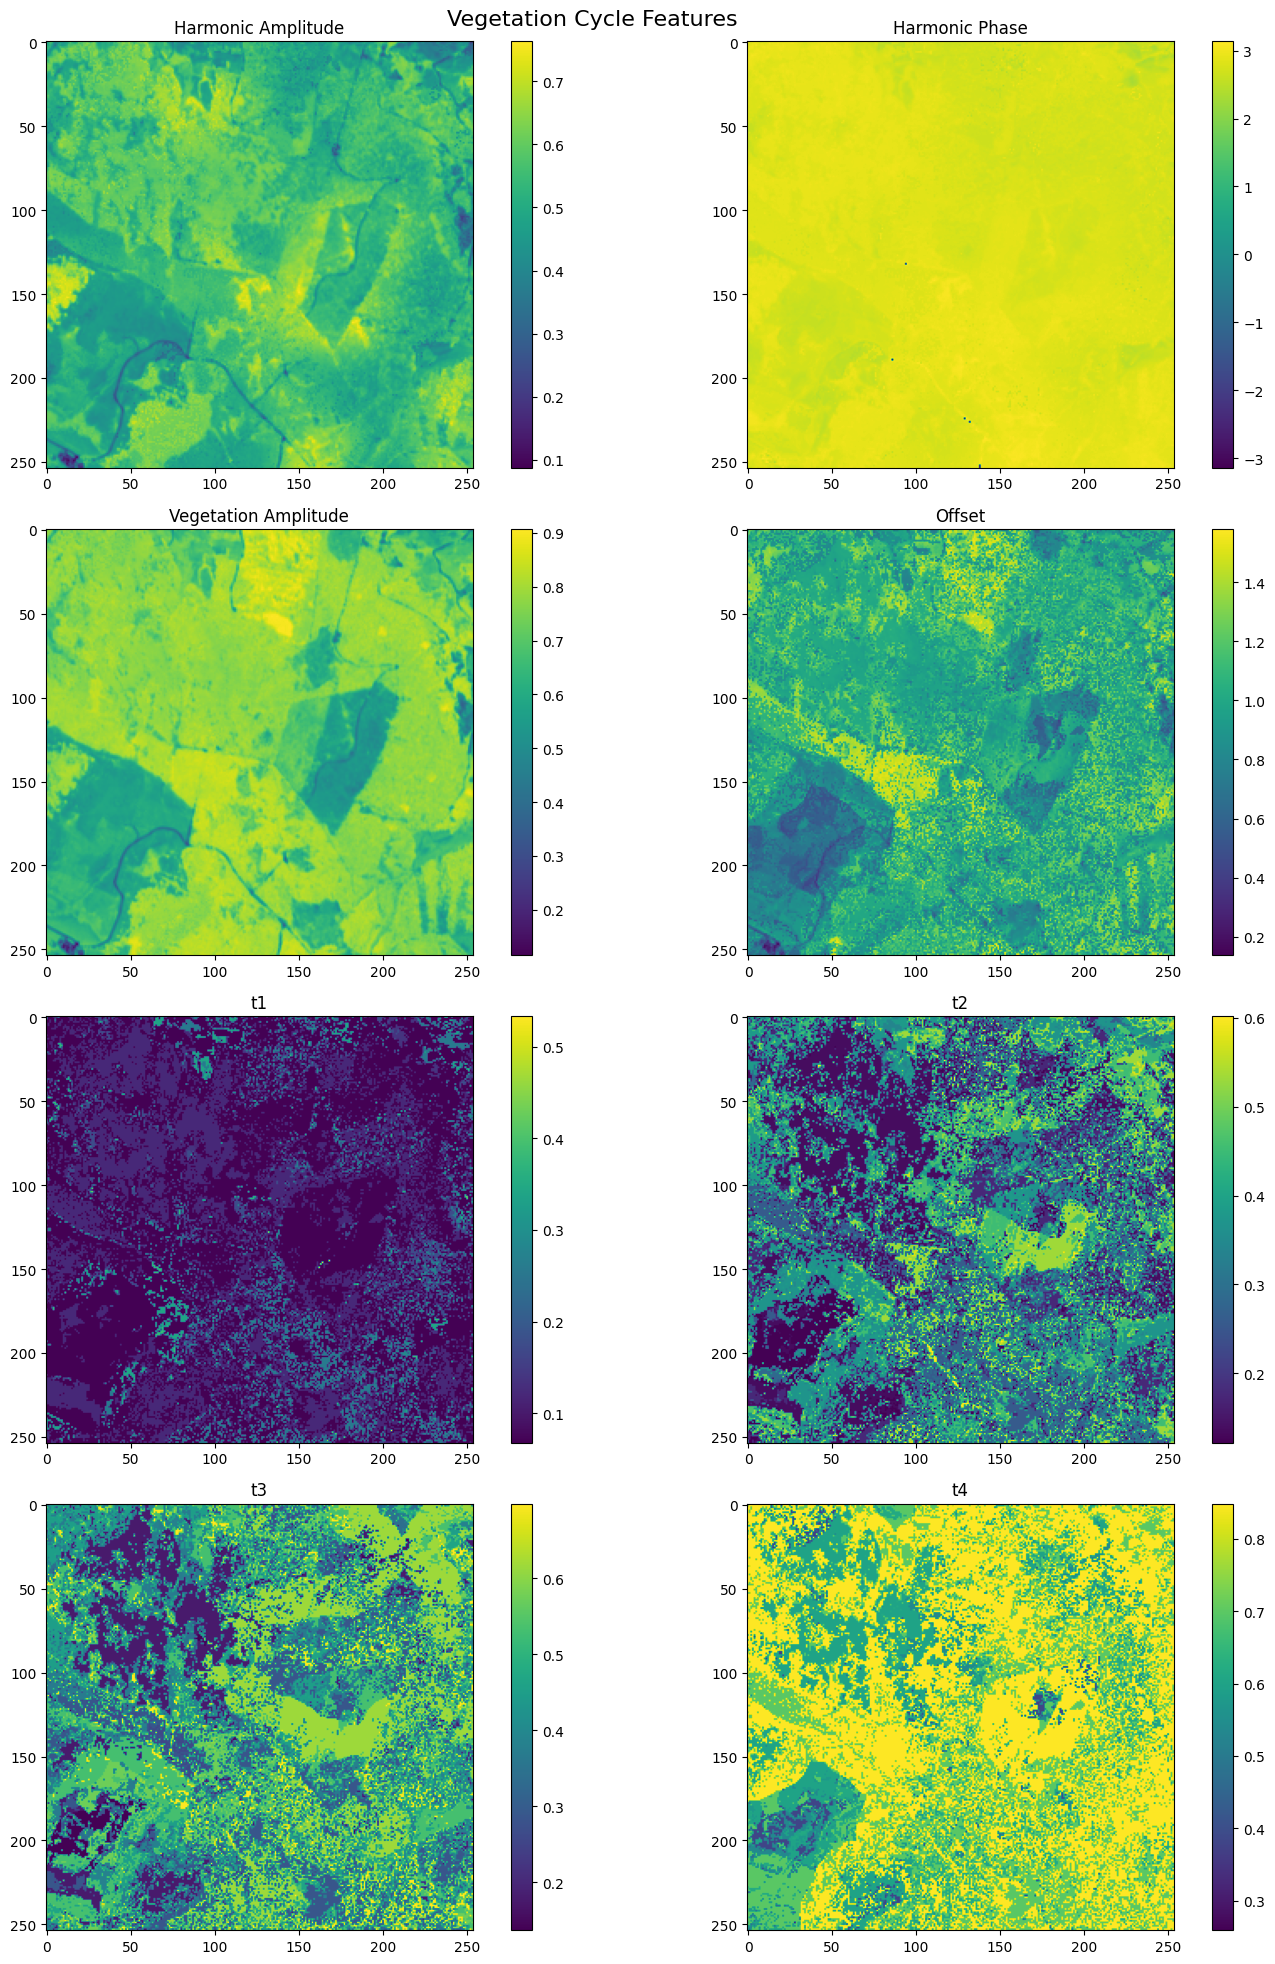

In [48]:
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_features(amplitude_harmonic_map, phase_harmonic_map, amplitude_vegetation_map, offset_map,
#                   t1_map, t2_map, t3_map, t4_map, save_path=None):
#     features = [
#         ('Harmonic Amplitude', amplitude_harmonic_map),
#         ('Harmonic Phase', phase_harmonic_map),
#         ('Vegetation Amplitude', amplitude_vegetation_map),
#         ('Offset', offset_map),
#         ('t1', t1_map),
#         ('t2', t2_map),
#         ('t3', t3_map),
#         ('t4', t4_map)
#     ]

#     n_features = len(features)
#     n_cols = 2
#     n_rows = (n_features + 1) // 2

#     fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
#     fig.suptitle('Vegetation Cycle Features', fontsize=16)

#     for i, (title, feature_map) in enumerate(features):
#         row = i // n_cols
#         col = i % n_cols
#         ax = axes[row, col]
        
#         im = ax.imshow(feature_map, cmap='viridis')
#         ax.set_title(title)
#         plt.colorbar(im, ax=ax)

#     # Remove any unused subplots
#     for i in range(n_features, n_rows * n_cols):
#         row = i // n_cols
#         col = i % n_cols
#         fig.delaxes(axes[row, col])

#     plt.tight_layout()
    
#     if save_path:
#         plt.savefig(save_path)
#         logger.info(f"Features plot saved to {save_path}")
#     else:
#         plt.show()

# # Usage example:
# # Assuming you have already run the fit_vegetation_cycle_with_breakpoints function
# # and have the results stored in variables

# os.makedirs('images', exist_ok=True)
# results = amplitude_harmonic_map, phase_harmonic_map, amplitude_vegetation_map, offset_map, \
#         t1_map, t2_map, t3_map, t4_map
# plot_features(*results, save_path='images/vegetation_cycle_features.png')

AttributeError: 'tuple' object has no attribute 'get_figure'

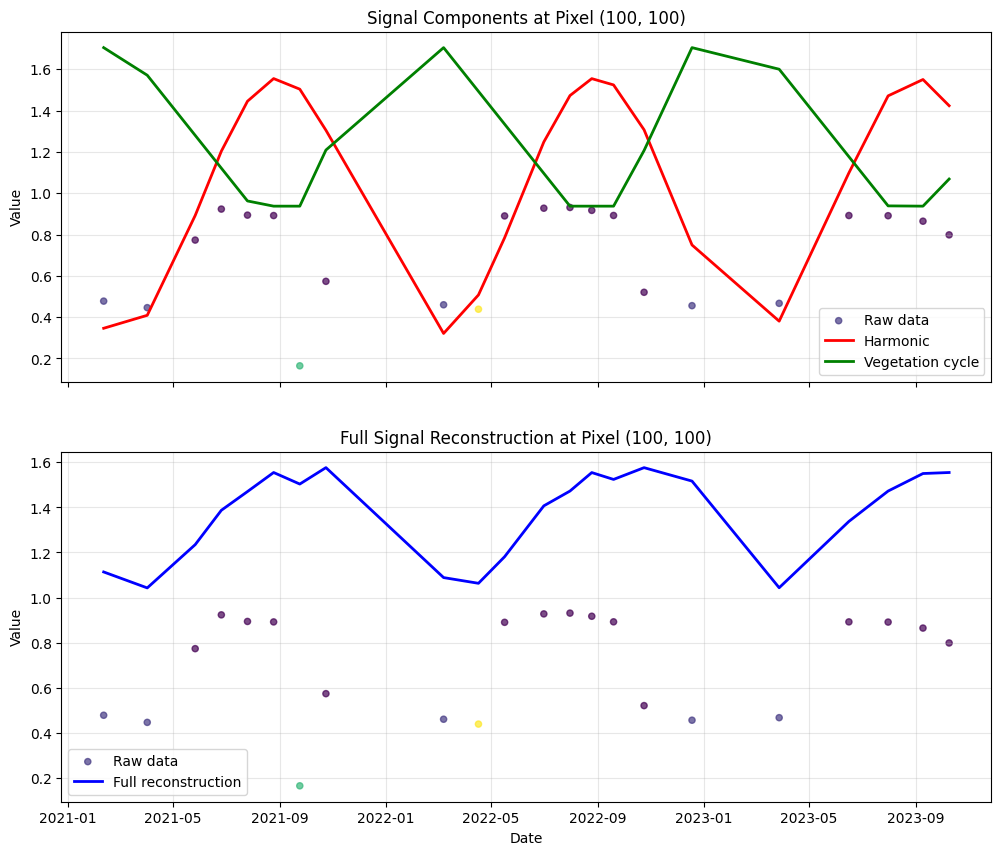

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List
from datetime import datetime

def reconstruct_signal_components(t: np.ndarray, pixel_params: Tuple[float, float, float, float, float, float, float, float]) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Reconstruct the signal components for a single pixel.
    
    :param t: Normalized time array (0 to 1)
    :param pixel_params: Tuple of (amplitude_harmonic, phase_harmonic, amplitude_vegetation, offset, t1, t2, t3, t4)
    :return: Tuple of (harmonic component, vegetation cycle component, full reconstructed signal)
    """
    amplitude_harmonic, phase_harmonic, amplitude_vegetation, offset, t1, t2, t3, t4 = pixel_params
    
    # Harmonic component
    harmonic = amplitude_harmonic * np.cos(2 * np.pi * t + phase_harmonic)
    
    # Vegetation cycle component
    veg_cycle = np.zeros_like(t)
    veg_cycle[(t >= t4) | (t < t1)] = amplitude_vegetation  # High plateau
    veg_cycle[(t >= t2) & (t < t3)] = 0  # Low plateau
    mask_decrease = (t >= t1) & (t < t2)
    veg_cycle[mask_decrease] = amplitude_vegetation * (1 - (t[mask_decrease] - t1) / (t2 - t1))
    mask_increase = (t >= t3) & (t < t4)
    veg_cycle[mask_increase] = amplitude_vegetation * ((t[mask_increase] - t3) / (t4 - t3))
    
    # Full reconstructed signal
    full_signal = harmonic + veg_cycle + offset
    
    return harmonic, veg_cycle, full_signal

def plot_pixel_decomposition(time_series: np.ndarray, qa: np.ndarray, dates: List[datetime], results: Tuple[np.ndarray, ...], pixel: Tuple[int, int]):
    """
    Plot decomposition of the signal for a specific pixel, showing harmonic and piecewise linear components separately.
    
    :param time_series: Original time series data
    :param qa: Quality assessment data
    :param dates: List of dates
    :param results: Results from fit_vegetation_cycle_with_breakpoints
    :param pixel: Tuple of (row, col) for the pixel to plot
    """
    # Extract pixel data
    row, col = pixel
    pixel_data = time_series[:, row, col]
    pixel_qa = qa[:, row, col]
    
    # Prepare time array
    times_datetime64 = np.array(dates, dtype='datetime64[D]')
    start_date = times_datetime64[0]
    days_since_start = (times_datetime64 - start_date).astype(int)
    t = days_since_start / 365.25  # Normalize to fraction of year
    t = np.mod(t, 1.0)  # Ensure t is between 0 and 1
    
    # Extract pixel parameters
    pixel_params = tuple(result[row, col] for result in results)
    
    # Reconstruct signal components
    harmonic, veg_cycle, full_signal = reconstruct_signal_components(t, pixel_params)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # Plot components on the first subplot
    ax1.scatter(dates, pixel_data, c=pixel_qa, cmap='viridis', label='Raw data', alpha=0.7, s=20)
    ax1.plot(dates, harmonic + pixel_params[3], 'r-', label='Harmonic', linewidth=2)
    ax1.plot(dates, veg_cycle + pixel_params[3], 'g-', label='Vegetation cycle', linewidth=2)
    ax1.set_title(f'Signal Components at Pixel ({row}, {col})')
    ax1.set_ylabel('Value')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot full reconstruction on the second subplot
    ax2.scatter(dates, pixel_data, c=pixel_qa, cmap='viridis', label='Raw data', alpha=0.7, s=20)
    ax2.plot(dates, full_signal, 'b-', label='Full reconstruction', linewidth=2)
    ax2.set_title(f'Full Signal Reconstruction at Pixel ({row}, {col})')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Value')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Add colorbar for quality assessment
    scatter = ax2.scatter(dates, pixel_data, c=pixel_qa, cmap='viridis', alpha=0)
    cbar = plt.colorbar(scatter, ax=(ax1, ax2), label='Quality Assessment')
    
    # Formatting x-axis to show dates nicely
    fig.autofmt_xdate()
    
    plt.tight_layout()
    plt.show()

# Usage example:
# Assuming you have already run the fit_vegetation_cycle_with_breakpoints function
# and have the results stored in the 'results' variable

# Choose a pixel to visualize (e.g., row 100, column 100)
pixel_to_visualize = (100, 100)

# Plot the decomposition
plot_pixel_decomposition(time_series, qa, dates, results, pixel_to_visualize)